# Exploration 7. IMDb 영화리뷰 감성분석

![image](https://user-images.githubusercontent.com/84179578/128654348-631dc893-cc14-4321-9543-43aefff28c05.png)





IMDb Large Movie Dataset은 50000개의 영어로 작성된 영화 리뷰 텍스트로 구성되어 있으며, 긍정은 1, 부정은 0의 라벨로 구성되어 있다.  

IMDb 영화리뷰 감성분석을 실제로 진행해보자.

_이후 스텝의 IMDb 데이터셋 처리 코드 중 일부는 Tensorflow 튜토리얼에 언급된 데이터 전처리 로직을 참고하였음_


## 1. 데이터 불러오기 및 전처리

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.4.1
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


`imdb.load_data()` 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 그 개수만큼의 `word_to_index` 딕셔너리까지 생성된 형태로 데이터셋이 생성된다.

In [2]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드받았음을 확인할 수 있음

In [4]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력
print(word_to_index['the'])  # 1 이 출력

the
1


IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 아래와 같이 보정되어야 한다.  

`word_to_index` 는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어있다.

In [5]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]



# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외



# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


encode된 텍스트가 정상적으로 decode되는지 확인해보자.

In [8]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

`pad_sequences` 를 통해 데이터셋 상의 문장의 길이를 통일해야한다.

문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.

In [9]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


### padding 적용

padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다.

RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다.  

따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 된다.

In [10]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 2. RNN 모델 설계

In [11]:

vocab_size = 10000 # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 16 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 설계.

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### validation set 분리

In [12]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


## 3. 모델 학습 및 평가

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 7s 138ms/step - loss: 0.6922 - accuracy: 0.5308 - val_loss: 0.6870 - val_accuracy: 0.5880
Epoch 2/20
30/30 [==============================] - 3s 112ms/step - loss: 0.6797 - accuracy: 0.6192 - val_loss: 0.6558 - val_accuracy: 0.6599
Epoch 3/20
30/30 [==============================] - 3s 112ms/step - loss: 0.6091 - accuracy: 0.7245 - val_loss: 0.4982 - val_accuracy: 0.8270
Epoch 4/20
30/30 [==============================] - 3s 112ms/step - loss: 0.5272 - accuracy: 0.7985 - val_loss: 0.4828 - val_accuracy: 0.8201
Epoch 5/20
30/30 [==============================] - 3s 108ms/step - loss: 0.4213 - accuracy: 0.8664 - val_loss: 0.4237 - val_accuracy: 0.8416
Epoch 6/20
30/30 [==============================] - 3s 107ms/step - loss: 0.3354 - accuracy: 0.9007 - val_loss: 0.4032 - val_accuracy: 0.8471
Epoch 7/20
30/30 [==============================] - 3s 107ms/step - loss: 0.2880 - accuracy: 0.9145 - val_loss: 0.3765 - val_accuracy: 0.8503
Epoch 

학습이 끝난 모델을 test set 으로 평가

In [14]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 21s - loss: 0.5518 - accuracy: 0.8345
[0.5518251657485962, 0.8345199823379517]


### 학습과정 시각화

In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


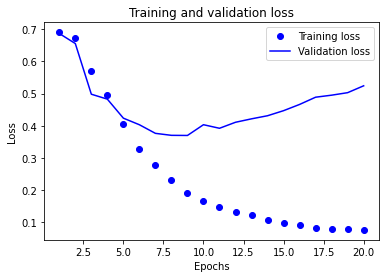

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

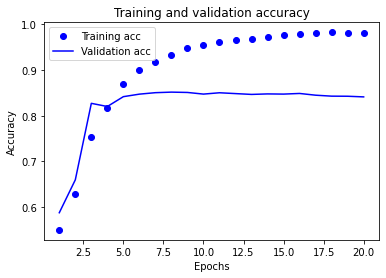

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정할 수 있다.

## Word2Vec 적용

이전 스텝에서 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법으로 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법으 사용하였다.

사용했던 model의 첫 번째 레이어는 바로 Embedding 레이어였다. 이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였다.  

만약 우리의 감성분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것. 

한번 확인해보자.

워드벡터를 다루는데 유용한 `gensim` 패키지를 설치한다.
```
$ pip install gensim
```

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

`gensim`에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용 가능하다.

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.03434632,  0.05501131,  0.01996197, -0.00385678,  0.07030047,
       -0.04595968, -0.02682209, -0.02869963, -0.00058966,  0.0657869 ,
       -0.0168556 ,  0.00032998, -0.01604367,  0.0455179 ,  0.00747465,
        0.03030313], dtype=float32)

워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있다. `gensim` 을 사용해 아래와 같이 해보자.

In [23]:
word_vectors.similar_by_word("love")

[('round', 0.97539222240448),
 ('stanwyck', 0.9742845296859741),
 ('reverse', 0.9733150005340576),
 ('learns', 0.9721903800964355),
 ('gas', 0.9701603055000305),
 ('vincenzo', 0.9691139459609985),
 ('readily', 0.9678806662559509),
 ('email', 0.9670338034629822),
 ('seat', 0.9666711688041687),
 ('larger', 0.9658933877944946)]

love라는 단어와 유사한 다른 단어를 그리 잘 찾았다고 느껴지지는 않는다.  

감성분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 어려운 것 같다. 우리가 다룬 정도의 훈련데이터로는 워드 벡터를 정교하게 학습시키기 어렵다.

그래서 이번에는 구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 가져다 활용해 보겠다.   
Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었다. 총 300만 개의 단어를 각각 300차원의 벡터로 표현한 것이다.

In [24]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

300dim의 벡터로 이루어진 300만 개의 단어이다.  
`KeyedVectors.load_word2vec_format` 메소드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩하였다.

In [25]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있다.  
이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜보자.

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [27]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 114, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [28]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 16s 447ms/step - loss: 0.6996 - accuracy: 0.5200 - val_loss: 0.6706 - val_accuracy: 0.6058
Epoch 2/20
30/30 [==============================] - 11s 376ms/step - loss: 0.6456 - accuracy: 0.6421 - val_loss: 0.5838 - val_accuracy: 0.7104
Epoch 3/20
30/30 [==============================] - 11s 385ms/step - loss: 0.5040 - accuracy: 0.7809 - val_loss: 0.5233 - val_accuracy: 0.7286
Epoch 4/20
30/30 [==============================] - 11s 370ms/step - loss: 0.3628 - accuracy: 0.8412 - val_loss: 0.3492 - val_accuracy: 0.8474
Epoch 5/20
30/30 [==============================] - 11s 372ms/step - loss: 0.2481 - accuracy: 0.9067 - val_loss: 0.3264 - val_accuracy: 0.8615
Epoch 6/20
30/30 [==============================] - 11s 374ms/step - loss: 0.1720 - accuracy: 0.9453 - val_loss: 0.3256 - val_accuracy: 0.8652
Epoch 7/20
30/30 [==============================] - 11s 366ms/step - loss: 0.1237 - accuracy: 0.9688 - val_loss: 0.3417 - val_accuracy: 0.8596

In [29]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 8s - loss: 0.6044 - accuracy: 0.8493
[0.6044328808784485, 0.8492799997329712]
